# Question 4

## (a)

In [ ]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

# Enter You Name Here
myname = "Soumi-Chakraborty"
K = 5
M = 8 # approximately equal to the square root of the number of features
N = 3067 # 2/3 of the total samples

class Node():
  def __init__(self, left=None, right=None, attribute_index=None, threshold=None, infoGain=None, label=None, depth=None, isLeaf=False):
    self.left = left
    self.right = right
    self.attribute_index = attribute_index
    self.threshold = threshold
    self.infoGain = infoGain
    self.label = label
    self.depth = depth
    self.isLeaf = isLeaf

# Implement your decision tree below
class DecisionTree():

    def getInfoGain(self, node, left, right):
      # infoGain = self.entropy(node) - (len(left) / len(node)) * self.entropy(left) - (len(right) / len(node)) * self.entropy(right) 
      infoGain = self.giniIndex(node) - ((np.shape(left)[0] / np.shape(node)[0]) * self.giniIndex(left) + (np.shape(right)[0] / np.shape(node)[0]) * self.giniIndex(right))

      return infoGain

    def giniIndex(self, y):
      #  since type can only be 0 or 1
      p0 = np.shape(y[y == 0])[0]/np.shape(y)[0]
      p1 = np.shape(y[y == 1])[0]/np.shape(y)[0]
      gini = 1 - p0**2 - p1**2
      return gini
      

    def learn(self, training_set):
        # implement this function
        X = training_set[:, :-1] # all rows, all columns except the last
        idx = np.random.choice(X.shape[1], M, replace=False)
        X = X[:, idx]
        y = training_set[:, -1]  # all rows, only the last column
        y = y.reshape(y.shape[0], 1)

        # purity check
        check = y[y == 1].shape[0]
        
        # # split if max depth not reached
        if check != 0 and check != y.shape[0]:
          # get best split
          splitDetails = {
              "infoGain" : None, 
              "leftTrainingSet": None, 
              "rightTrainingSet": None, 
              "attributeIndex" : None, 
              "threshold": None
          }
          
          # check over all the attributes
          bestInfoGain = -float("inf")
          for feature in idx:
            values = training_set[:, feature] 
            thersholds = np.unique(values)
            # compare all possible splits and choose the best one
            for thershold in thersholds:
              # divide the training set based on the threshold
              left_training_set = training_set[np.where(training_set[:, feature] <= thershold)]
              right_training_set = training_set[np.where(training_set[:, feature] > thershold)]
              if np.shape(left_training_set)[0] > 0 and np.shape(right_training_set)[0] > 0:
                yLeft = left_training_set[:, -1].reshape(np.shape(left_training_set)[0], 1)
                yRight = right_training_set[:, -1].reshape(np.shape(right_training_set)[0], 1)

                # get info gain
                infoGain = self.getInfoGain(y, yLeft, yRight)
                # update split
                if infoGain > bestInfoGain:
                  bestInfoGain = infoGain
                  splitDetails = {
                    "infoGain" : infoGain, 
                    "leftTrainingSet": left_training_set, 
                    "rightTrainingSet": right_training_set, 
                    "attributeIndex" : feature, 
                    "threshold": thershold
                    }

          # check if node is impure 
          if splitDetails["infoGain"] != None and splitDetails["infoGain"] > 0:
            # repeat for left side
            left = self.learn(splitDetails["leftTrainingSet"])
            # repeat for left side
            right = self.learn(splitDetails["rightTrainingSet"])
            # return new node
            return Node(left, right, splitDetails["attributeIndex"], splitDetails["threshold"])
        
        # if the control reaches here, the node under consideration is a leaf node
        zeros = np.shape(y[y == 0])[0]
        ones = np.shape(y[y == 1])[0]
        if zeros > ones:
          return Node(label=0, isLeaf=True)
        else:
          return Node(label=1, isLeaf=True)

    def classify(self, root, test_instance):
        result = 0 # baseline: always classifies as 0
        if root.isLeaf == True:
          return root.label
        if test_instance[root.attribute_index] <= root.threshold:
          return self.classify(root.left, test_instance)
        else:
          return self.classify(root.right, test_instance)


def run_decision_tree():

    # Load data set
    data_set_path = "https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"
    data = np.loadtxt(data_set_path)

    # Split training/test sets
    X = data[:, :-1] # all rows, all columns except the last
    y = data[:, -1]  # all rows, only the last column

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    y_train_matrix = y_train.reshape(y_train.shape[0], 1)
    y_test_matrix = y_test.reshape(y_test.shape[0], 1)

    training_set = np.hstack((X_train, y_train_matrix))
    test_set = np.hstack((X_test, y_test_matrix))

    training_set = np.asarray(training_set, dtype=np.float32)
    test_set = np.asarray(test_set, dtype=np.float32)

    print("Building the random forest...")
    predictions = np.zeros((test_set.shape[0], K)) # array to store the predictions in
    for i in range(K):
      # create subset of the dataset
      training_subset = training_set[np.random.choice(training_set.shape[0], N, replace=True), :]
      tree = DecisionTree()
      root = Node()
      # Construct a tree using training set
      root = tree.learn(training_subset)

      # Classify the test set using the tree we just constructed
      sample = 0
      for instance in test_set:
          result = tree.classify(root, instance[:-1])
          # print(result)
          # results.append(result == int(instance[-1]))
          # predictions[sample] = (result == int(instance[-1]))
          predictions[sample] = result

          sample = sample + 1

    majority = stats.mode(predictions.T)
    final_predictions = majority[0][0]

    results = (final_predictions == y_test)
    
    # Accuracy
    accuracy = float(np.count_nonzero(results))/float(results.shape[0])
    print("accuracy: %.4f" % accuracy)


    # Writing results to a file (DO NOT CHANGE)
    f = open(myname+"result.txt", "w")
    f.write("accuracy: %.4f" % accuracy)
    f.close()

    # comparing with sklearn
    print("Using sklearn to build the random forest...")
    # clf = RandomForestClassifier(n_estimators=K, max_features=M, bootstrap=True, max_samples=N, random_state=0)
    clf = RandomForestClassifier(n_estimators=K, max_features=M, bootstrap=True, max_samples=N)
    clf.fit(X_train, y_train)
    lib_predictions = clf.predict(X_test)

    lib_results = (lib_predictions == y_test)

    # Accuracy
    lib_accuracy = float(np.count_nonzero(lib_results))/float(lib_results.shape[0])
    print("accuracy: %.4f" % lib_accuracy)



if __name__ == "__main__":
    run_decision_tree()

Building the random forest...
accuracy: 0.9015
Using sklearn to build the random forest...
accuracy: 0.9327


Running the same code with a 100 trees

In [ ]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

# Enter You Name Here
myname = "Soumi-Chakraborty"
K = 100
M = 15 # approximately equal to the square root of the number of features
N = 2000 # 2/3 of the training set

class Node():
  def __init__(self, left=None, right=None, attribute_index=None, threshold=None, infoGain=None, label=None, depth=None, isLeaf=False):
    self.left = left
    self.right = right
    self.attribute_index = attribute_index
    self.threshold = threshold
    self.infoGain = infoGain
    self.label = label
    self.depth = depth
    self.isLeaf = isLeaf

# Implement your decision tree below
class DecisionTree():

    def getInfoGain(self, node, left, right):
      # infoGain = self.entropy(node) - (len(left) / len(node)) * self.entropy(left) - (len(right) / len(node)) * self.entropy(right) 
      infoGain = self.giniIndex(node) - ((np.shape(left)[0] / np.shape(node)[0]) * self.giniIndex(left) + (np.shape(right)[0] / np.shape(node)[0]) * self.giniIndex(right))

      return infoGain

    def giniIndex(self, y):
      #  since type can only be 0 or 1
      p0 = np.shape(y[y == 0])[0]/np.shape(y)[0]
      p1 = np.shape(y[y == 1])[0]/np.shape(y)[0]
      gini = 1 - p0**2 - p1**2
      return gini
      

    def learn(self, training_set):
        # implement this function
        X = training_set[:, :-1] # all rows, all columns except the last
        idx = np.random.choice(X.shape[1], M, replace=False)
        X = X[:, idx]
        y = training_set[:, -1]  # all rows, only the last column
        y = y.reshape(y.shape[0], 1)

        # purity check
        check = y[y == 1].shape[0]
        
        # # split if max depth not reached
        if check != 0 and check != y.shape[0]:
          # get best split
          splitDetails = {
              "infoGain" : None, 
              "leftTrainingSet": None, 
              "rightTrainingSet": None, 
              "attributeIndex" : None, 
              "threshold": None
          }
          
          # check over all the attributes
          bestInfoGain = -float("inf")
          for feature in idx:
            values = training_set[:, feature] 
            thersholds = np.unique(values)
            # compare all possible splits and choose the best one
            for thershold in thersholds:
              # divide the training set based on the threshold
              left_training_set = training_set[np.where(training_set[:, feature] <= thershold)]
              right_training_set = training_set[np.where(training_set[:, feature] > thershold)]
              if np.shape(left_training_set)[0] > 0 and np.shape(right_training_set)[0] > 0:
                yLeft = left_training_set[:, -1].reshape(np.shape(left_training_set)[0], 1)
                yRight = right_training_set[:, -1].reshape(np.shape(right_training_set)[0], 1)

                # get info gain
                infoGain = self.getInfoGain(y, yLeft, yRight)
                # update split
                if infoGain > bestInfoGain:
                  bestInfoGain = infoGain
                  splitDetails = {
                    "infoGain" : infoGain, 
                    "leftTrainingSet": left_training_set, 
                    "rightTrainingSet": right_training_set, 
                    "attributeIndex" : feature, 
                    "threshold": thershold
                    }

          # check if node is impure 
          if splitDetails["infoGain"] != None and splitDetails["infoGain"] > 0:
            # repeat for left side
            left = self.learn(splitDetails["leftTrainingSet"])
            # repeat for left side
            right = self.learn(splitDetails["rightTrainingSet"])
            # return new node
            return Node(left, right, splitDetails["attributeIndex"], splitDetails["threshold"])
        
        # if the control reaches here, the node under consideration is a leaf node
        zeros = np.shape(y[y == 0])[0]
        ones = np.shape(y[y == 1])[0]
        if zeros > ones:
          return Node(label=0, isLeaf=True)
        else:
          return Node(label=1, isLeaf=True)

    def classify(self, root, test_instance):
        result = 0 # baseline: always classifies as 0
        if root.isLeaf == True:
          return root.label
        if test_instance[root.attribute_index] <= root.threshold:
          return self.classify(root.left, test_instance)
        else:
          return self.classify(root.right, test_instance)


def run_decision_tree():

    # Load data set
    data_set_path = "https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"
    data = np.loadtxt(data_set_path)

    # Split training/test sets
    X = data[:, :-1] # all rows, all columns except the last
    y = data[:, -1]  # all rows, only the last column

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    y_train_matrix = y_train.reshape(y_train.shape[0], 1)
    y_test_matrix = y_test.reshape(y_test.shape[0], 1)

    training_set = np.hstack((X_train, y_train_matrix))
    test_set = np.hstack((X_test, y_test_matrix))

    training_set = np.asarray(training_set, dtype=np.float32)
    test_set = np.asarray(test_set, dtype=np.float32)

    print("Building the random forest...")
    predictions = np.zeros((test_set.shape[0], K)) # array to store the predictions in
    for i in range(K):
      # create subset of the dataset
      training_subset = training_set[np.random.choice(training_set.shape[0], N, replace=True), :]
      tree = DecisionTree()
      root = Node()
      # Construct a tree using training set
      root = tree.learn(training_subset)

      # Classify the test set using the tree we just constructed
      sample = 0
      for instance in test_set:
          result = tree.classify(root, instance[:-1])
          # print(result)
          # results.append(result == int(instance[-1]))
          # predictions[sample] = (result == int(instance[-1]))
          predictions[sample] = result

          sample = sample + 1

    majority = stats.mode(predictions.T)
    final_predictions = majority[0][0]

    results = (final_predictions == y_test)
    
    # Accuracy
    accuracy = float(np.count_nonzero(results))/float(results.shape[0])
    print("accuracy: %.4f" % accuracy)


    # Writing results to a file (DO NOT CHANGE)
    f = open(myname+"result.txt", "w")
    f.write("accuracy: %.4f" % accuracy)
    f.close()

    # comparing with sklearn
    print("Using sklearn to build the random forest...")
    # clf = RandomForestClassifier(n_estimators=K, max_features=M, bootstrap=True, max_samples=N, random_state=0)
    clf = RandomForestClassifier(n_estimators=K, max_features=M, bootstrap=True, max_samples=N)
    clf.fit(X_train, y_train)
    lib_predictions = clf.predict(X_test)

    lib_results = (lib_predictions == y_test)

    # Accuracy
    lib_accuracy = float(np.count_nonzero(lib_results))/float(lib_results.shape[0])
    print("accuracy: %.4f" % lib_accuracy)



if __name__ == "__main__":
    run_decision_tree()

Building the random forest...
accuracy: 0.8812
Using sklearn to build the random forest...
accuracy: 0.9500


## (b)

m: 2
accuracy: 0.8697
m: 4
accuracy: 0.8776
m: 8
accuracy: 0.8892
m: 15
accuracy: 0.8805
m: 20
accuracy: 0.8907
m: 25
accuracy: 0.8870
m: 30
accuracy: 0.8769
m: 35
accuracy: 0.8950
m: 40
accuracy: 0.8668
m: 58
accuracy: 0.8849


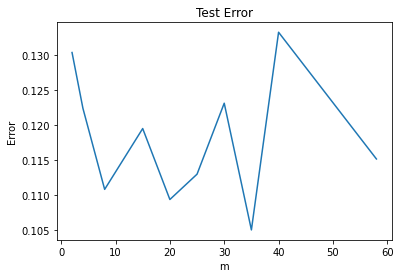

In [ ]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib.pyplot as plt

# Enter You Name Here
myname = "Soumi-Chakraborty"
K = 5
M = 8 # approximately equal to the square root of the number of features
N = 3067 # 2/3 of the total samples

class Node():
  def __init__(self, left=None, right=None, attribute_index=None, threshold=None, infoGain=None, label=None, depth=None, isLeaf=False):
    self.left = left
    self.right = right
    self.attribute_index = attribute_index
    self.threshold = threshold
    self.infoGain = infoGain
    self.label = label
    self.depth = depth
    self.isLeaf = isLeaf

# Implement your decision tree below
class DecisionTree():

    def getInfoGain(self, node, left, right):
      # infoGain = self.entropy(node) - (len(left) / len(node)) * self.entropy(left) - (len(right) / len(node)) * self.entropy(right) 
      infoGain = self.giniIndex(node) - ((np.shape(left)[0] / np.shape(node)[0]) * self.giniIndex(left) + (np.shape(right)[0] / np.shape(node)[0]) * self.giniIndex(right))

      return infoGain

    def giniIndex(self, y):
      #  since type can only be 0 or 1
      p0 = np.shape(y[y == 0])[0]/np.shape(y)[0]
      p1 = np.shape(y[y == 1])[0]/np.shape(y)[0]
      gini = 1 - p0**2 - p1**2
      return gini
      

    def learn(self, training_set):
        # implement this function
        X = training_set[:, :-1] # all rows, all columns except the last
        idx = np.random.choice(X.shape[1], M, replace=False)
        X = X[:, idx]
        y = training_set[:, -1]  # all rows, only the last column
        y = y.reshape(y.shape[0], 1)

        # purity check
        check = y[y == 1].shape[0]
        
        # # split if max depth not reached
        if check != 0 and check != y.shape[0]:
          # get best split
          splitDetails = {
              "infoGain" : None, 
              "leftTrainingSet": None, 
              "rightTrainingSet": None, 
              "attributeIndex" : None, 
              "threshold": None
          }
          
          # check over all the attributes
          bestInfoGain = -float("inf")
          for feature in idx:
            values = training_set[:, feature] 
            thersholds = np.unique(values)
            # compare all possible splits and choose the best one
            for thershold in thersholds:
              # divide the training set based on the threshold
              left_training_set = training_set[np.where(training_set[:, feature] <= thershold)]
              right_training_set = training_set[np.where(training_set[:, feature] > thershold)]
              if np.shape(left_training_set)[0] > 0 and np.shape(right_training_set)[0] > 0:
                yLeft = left_training_set[:, -1].reshape(np.shape(left_training_set)[0], 1)
                yRight = right_training_set[:, -1].reshape(np.shape(right_training_set)[0], 1)

                # get info gain
                infoGain = self.getInfoGain(y, yLeft, yRight)
                # update split
                if infoGain > bestInfoGain:
                  bestInfoGain = infoGain
                  splitDetails = {
                    "infoGain" : infoGain, 
                    "leftTrainingSet": left_training_set, 
                    "rightTrainingSet": right_training_set, 
                    "attributeIndex" : feature, 
                    "threshold": thershold
                    }

          # check if node is impure 
          if splitDetails["infoGain"] != None and splitDetails["infoGain"] > 0:
            # repeat for left side
            left = self.learn(splitDetails["leftTrainingSet"])
            # repeat for left side
            right = self.learn(splitDetails["rightTrainingSet"])
            # return new node
            return Node(left, right, splitDetails["attributeIndex"], splitDetails["threshold"])
        
        # if the control reaches here, the node under consideration is a leaf node
        zeros = np.shape(y[y == 0])[0]
        ones = np.shape(y[y == 1])[0]
        if zeros > ones:
          return Node(label=0, isLeaf=True)
        else:
          return Node(label=1, isLeaf=True)

    def classify(self, root, test_instance):
        result = 0 # baseline: always classifies as 0
        if root.isLeaf == True:
          return root.label
        if test_instance[root.attribute_index] <= root.threshold:
          return self.classify(root.left, test_instance)
        else:
          return self.classify(root.right, test_instance)


def run_decision_tree(n_features):

    M = n_features

    # Load data set
    data_set_path = "https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"
    data = np.loadtxt(data_set_path)

    # Split training/test sets
    X = data[:, :-1] # all rows, all columns except the last
    y = data[:, -1]  # all rows, only the last column

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    y_train_matrix = y_train.reshape(y_train.shape[0], 1)
    y_test_matrix = y_test.reshape(y_test.shape[0], 1)

    training_set = np.hstack((X_train, y_train_matrix))
    test_set = np.hstack((X_test, y_test_matrix))

    training_set = np.asarray(training_set, dtype=np.float32)
    test_set = np.asarray(test_set, dtype=np.float32)

    # print("Building the random forest...")
    predictions = np.zeros((test_set.shape[0], K)) # array to store the predictions in
    for i in range(K):
      # create subset of the dataset
      training_subset = training_set[np.random.choice(training_set.shape[0], N, replace=True), :]
      tree = DecisionTree()
      root = Node()
      # Construct a tree using training set
      root = tree.learn(training_subset)

      # Classify the test set using the tree we just constructed
      sample = 0
      for instance in test_set:
          result = tree.classify(root, instance[:-1])
          # print(result)
          # results.append(result == int(instance[-1]))
          # predictions[sample] = (result == int(instance[-1]))
          predictions[sample] = result

          sample = sample + 1

    majority = stats.mode(predictions.T)
    final_predictions = majority[0][0]

    results = (final_predictions == y_test)
    
    # Accuracy
    accuracy = float(np.count_nonzero(results))/float(results.shape[0])
    print("accuracy: %.4f" % accuracy)


    # Writing results to a file (DO NOT CHANGE)
    f = open(myname+"result.txt", "w")
    f.write("accuracy: %.4f" % accuracy)
    f.close()

    return accuracy

test_error = []
if __name__ == "__main__":
    m_choices = [2, 4, 8, 15, 20, 25, 30, 35, 40, 58] # (1/2) * sqrt(#features), sqrt(#features), 2 * sqrt(#features)
    for m in m_choices:
        print("m:", m)
        acc = run_decision_tree(m)
        test_error.append(1 - acc)

    # plt.plot(test_error)
    plt.plot(m_choices, test_error)
    plt.title('Test Error')
    plt.xlabel('m')
    plt.ylabel('Error')
    plt.show()

The values of $m$ were chosen to be $\frac{1}{2} \sqrt M$, $\sqrt M$, $2 \sqrt M$ and the total number fo features where $M$ is the total number of features. The other values of $m$ were chosen at random for the sake of testing. The graph shows that when $m$ is equal to the suggested values, the error is usually comparatively smaller.

## (c)

m: 2
OOB samples accuracy: 0.9059
OOB samples error: 0.0941
m: 4
OOB samples accuracy: 0.9109
OOB samples error: 0.0891
m: 8
OOB samples accuracy: 0.9124
OOB samples error: 0.0876
m: 15
OOB samples accuracy: 0.9115
OOB samples error: 0.0885
m: 20
OOB samples accuracy: 0.9040
OOB samples error: 0.0960
m: 25
OOB samples accuracy: 0.9102
OOB samples error: 0.0898
m: 30
OOB samples accuracy: 0.9056
OOB samples error: 0.0944
m: 35
OOB samples accuracy: 0.9090
OOB samples error: 0.0910
m: 40
OOB samples accuracy: 0.9174
OOB samples error: 0.0826
m: 58
OOB samples accuracy: 0.9106
OOB samples error: 0.0894


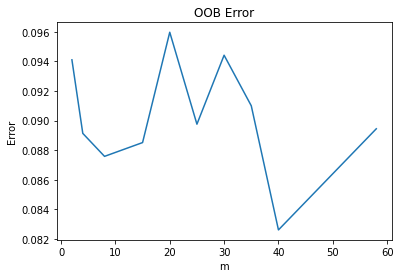

In [ ]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib.pyplot as plt


# Enter You Name Here
myname = "Soumi-Chakraborty"
K = 5
M = 8 # approximately equal to the square root of the number of features
N = 3067 # 2/3 of the total samples

class Node():
  def __init__(self, left=None, right=None, attribute_index=None, threshold=None, infoGain=None, label=None, depth=None, isLeaf=False):
    self.left = left
    self.right = right
    self.attribute_index = attribute_index
    self.threshold = threshold
    self.infoGain = infoGain
    self.label = label
    self.depth = depth
    self.isLeaf = isLeaf

# Implement your decision tree below
class DecisionTree():

    def getInfoGain(self, node, left, right):
      # infoGain = self.entropy(node) - (len(left) / len(node)) * self.entropy(left) - (len(right) / len(node)) * self.entropy(right) 
      infoGain = self.giniIndex(node) - ((np.shape(left)[0] / np.shape(node)[0]) * self.giniIndex(left) + (np.shape(right)[0] / np.shape(node)[0]) * self.giniIndex(right))

      return infoGain

    def giniIndex(self, y):
      #  since type can only be 0 or 1
      p0 = np.shape(y[y == 0])[0]/np.shape(y)[0]
      p1 = np.shape(y[y == 1])[0]/np.shape(y)[0]
      gini = 1 - p0**2 - p1**2
      return gini
      

    def learn(self, training_set):
        # implement this function
        X = training_set[:, :-1] # all rows, all columns except the last
        idx = np.random.choice(X.shape[1], M, replace=False)
        X = X[:, idx]
        y = training_set[:, -1]  # all rows, only the last column
        y = y.reshape(y.shape[0], 1)

        # purity check
        check = y[y == 1].shape[0]
        
        # # split if max depth not reached
        if check != 0 and check != y.shape[0]:
          # get best split
          splitDetails = {
              "infoGain" : None, 
              "leftTrainingSet": None, 
              "rightTrainingSet": None, 
              "attributeIndex" : None, 
              "threshold": None
          }
          
          # check over all the attributes
          bestInfoGain = -float("inf")
          for feature in idx:
            values = training_set[:, feature] 
            thersholds = np.unique(values)
            # compare all possible splits and choose the best one
            for thershold in thersholds:
              # divide the training set based on the threshold
              left_training_set = training_set[np.where(training_set[:, feature] <= thershold)]
              right_training_set = training_set[np.where(training_set[:, feature] > thershold)]
              if np.shape(left_training_set)[0] > 0 and np.shape(right_training_set)[0] > 0:
                yLeft = left_training_set[:, -1].reshape(np.shape(left_training_set)[0], 1)
                yRight = right_training_set[:, -1].reshape(np.shape(right_training_set)[0], 1)

                # get info gain
                infoGain = self.getInfoGain(y, yLeft, yRight)
                # update split
                if infoGain > bestInfoGain:
                  bestInfoGain = infoGain
                  splitDetails = {
                    "infoGain" : infoGain, 
                    "leftTrainingSet": left_training_set, 
                    "rightTrainingSet": right_training_set, 
                    "attributeIndex" : feature, 
                    "threshold": thershold
                    }

          # check if node is impure 
          if splitDetails["infoGain"] != None and splitDetails["infoGain"] > 0:
            # repeat for left side
            left = self.learn(splitDetails["leftTrainingSet"])
            # repeat for left side
            right = self.learn(splitDetails["rightTrainingSet"])
            # return new node
            return Node(left, right, splitDetails["attributeIndex"], splitDetails["threshold"])
        
        # if the control reaches here, the node under consideration is a leaf node
        zeros = np.shape(y[y == 0])[0]
        ones = np.shape(y[y == 1])[0]
        if zeros > ones:
          return Node(label=0, isLeaf=True)
        else:
          return Node(label=1, isLeaf=True)

    def classify(self, root, test_instance):
        result = 0 # baseline: always classifies as 0
        if root.isLeaf == True:
          return root.label
        if test_instance[root.attribute_index] <= root.threshold:
          return self.classify(root.left, test_instance)
        else:
          return self.classify(root.right, test_instance)


def run_decision_tree(n_features):

    M = n_features

    # Load data set
    data_set_path = "https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"
    data = np.loadtxt(data_set_path)

    # Split training/test sets
    X = data[:, :-1] # all rows, all columns except the last
    y = data[:, -1]  # all rows, only the last column

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    y_train_matrix = y_train.reshape(y_train.shape[0], 1)
    y_test_matrix = y_test.reshape(y_test.shape[0], 1)

    training_set = np.hstack((X_train, y_train_matrix))
    test_set = np.hstack((X_test, y_test_matrix))

    training_set = np.asarray(training_set, dtype=np.float32)
    test_set = np.asarray(test_set, dtype=np.float32)

    # creating dictionary for OOB score
    indices = np.arange(training_set.shape[0])
    OOB = {i: [] for i in range(training_set.shape[0])}

    # print("Building the random forest...")
    predictions = np.zeros((test_set.shape[0], K)) # array to store the predictions in
    for i in range(K):
      # create subset of the dataset
      selected_idx = np.random.choice(training_set.shape[0], N, replace=True)
      training_subset = training_set[selected_idx, :]
      tree = DecisionTree()
      root = Node()
      # Construct a tree using training set
      root = tree.learn(training_subset)

      # OOB error
      unselected_idx = [i for i in range(training_set.shape[0]) if i not in selected_idx]
      # OOB_sample = training_set[unselected_idx, :]

      # Classify the unselected samples using the tree we just constructed
      sample = 0
      for i in unselected_idx:
          result = tree.classify(root, training_set[i, :-1])
          OOB[i].append(result)

    final_predictions = np.zeros(training_set.shape[0])
    for i in range(training_set.shape[0]):
      if len(OOB[i]) == 0:
        final_predictions[i] = y_train[i]
      else:
        majority = stats.mode(OOB[i])
        final_predictions[i] = majority[0][0]

    results = (final_predictions == y_train)
    
    # Accuracy
    accuracy = float(np.count_nonzero(results))/float(results.shape[0])
    error = 1 - accuracy
    print("OOB samples accuracy: %.4f" % accuracy)
    print("OOB samples error: %.4f" % error)

    return accuracy



OOB_error = []
if __name__ == "__main__":
    m_choices = [2, 4, 8, 15, 20, 25, 30, 35, 40, 58] # (1/2) * sqrt(#features), sqrt(#features), 2 * sqrt(#features)
    for m in m_choices:
        print("m:", m)
        acc = run_decision_tree(m)
        OOB_error.append(1 - acc)

    # plt.plot(OOB_error)
    plt.plot(m_choices, OOB_error)
    plt.title('OOB Error')
    plt.xlabel('m')
    plt.ylabel('Error')
    plt.show()

The OOB error for the tree seems to very minor, thus showing that this forest is well built and not subject to overfitting and satisfies its objectives.

### Plotting

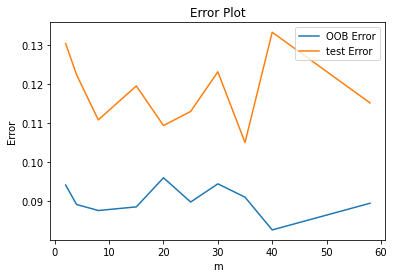

In [ ]:
m_choices = [2, 4, 8, 15, 20, 25, 30, 35, 40, 58]
plt.plot(m_choices, OOB_error, label='OOB Error')
plt.plot(m_choices, test_error, label='test Error')
plt.title('Error Plot')
plt.xlabel('m')
plt.ylabel('Error')
plt.legend(loc="upper right")
plt.show()

The graph between the OOB and the test error shows that the OOB samples were a little bit prone to overfitting because despite not having been in every decision tree, the fact that they were a part of at least one tree in the forest plays in their favour.

However, it can be noted from both the errors that the error is comparatively lower for the suggested "intermediate" values of $m$.

# Question 5

## (a)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# loan_train_path = "/content/drive/MyDrive/Acad_Stuff/Course Work/Semester 5/FoML/Ass3/loan_train.csv"
# loan_test_path = "/content/drive/MyDrive/Acad_Stuff/Course Work/Semester 5/FoML/Ass3/loan_test.csv"

loan_train_path = "loan_train.csv"
loan_test_path = "loan_test.csv"

### Pre-processing the train set

In [ ]:
loan_train = pd.read_csv(loan_train_path)
print(loan_train.shape, " - original dataset")

# dropping rows where loan_status == "current"
loan_train.drop(loan_train[loan_train.loan_status == "Current"].index, inplace=True)
loan_train.loc[loan_train['loan_status'] == "Charged Off", 'loan_status'] = 1
loan_train.loc[loan_train['loan_status'] == "Fully Paid", 'loan_status'] = -1

loan_train.loan_status = pd.to_numeric(loan_train.loan_status)

print(loan_train.shape, " - after removing the samples where the loan_status is Current")


# deleting columns which have majorly nan values or have only one unique value
for (columnName, columnData) in loan_train.iteritems():
    if loan_train[columnName].nunique(dropna = False) == 1:
      loan_train.drop(columnName, axis='columns', inplace=True)
    elif loan_train[columnName].isnull().sum() >= 10000:
      loan_train.drop(columnName, axis='columns', inplace=True)

print(loan_train.shape, " - after deleting features with only one value or a lot of NaN values")



# manual fine tuning

# eyeballing the features and removing seemingly unnecessary ones
loan_train.drop('url', axis='columns', inplace=True)
loan_train.drop('desc', axis='columns', inplace=True)
loan_train.drop('title', axis='columns', inplace=True)
loan_train.drop('emp_title', axis='columns', inplace=True)
loan_train.drop('emp_length', axis='columns', inplace=True)
loan_train.drop('collections_12_mths_ex_med', axis='columns', inplace=True)
loan_train.drop('last_pymnt_d', axis='columns', inplace=True)
loan_train.drop('last_credit_pull_d', axis='columns', inplace=True)
loan_train.drop('earliest_cr_line', axis='columns', inplace=True)
loan_train.drop('issue_d', axis='columns', inplace=True)

# filling missing values
loan_train.drop('chargeoff_within_12_mths', axis='columns', inplace=True)
loan_train.drop('tax_liens', axis='columns', inplace=True)

imputer = SimpleImputer(fill_value=np.nan, strategy='most_frequent')
loan_train.pub_rec_bankruptcies = imputer.fit_transform(loan_train['pub_rec_bankruptcies'].values.reshape(-1,1))[:,0]

loan_train.revol_util = loan_train['revol_util'].str.rstrip('%')
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
loan_train.revol_util = imputer.fit_transform(loan_train['revol_util'].values.reshape(-1,1))[:,0]

# removing the '%' symbol from a column to convert it to continuous data
loan_train.int_rate = loan_train['int_rate'].str.rstrip('%')


# label encoding the string columns
le = LabelEncoder()
for (columnName, columnData) in loan_train.iteritems():
  # print(columnName, loan_train[columnName].nunique(dropna = False))
  if loan_train.dtypes[columnName] == 'object':
    le.fit(loan_train[columnName])
    loan_train[columnName] = le.transform(loan_train[columnName])

print(loan_train.shape, " - final shape after preprocessing")

# loan_train.to_csv('/content/drive/MyDrive/Acad_Stuff/Course Work/Semester 5/FoML/Ass3/loan_train_m.csv', index=False)
loan_train.to_csv('loan_train_m.csv', index=False)



(24999, 111)  - original dataset
(24301, 111)  - after removing the samples where the loan_status is Current
(24301, 46)  - after deleting features with only one value or a lot of NaN values
(24301, 34)  - final shape after preprocessing


### Pre-proccessing the test set

In [ ]:
loan_test = pd.read_csv(loan_test_path)
print(loan_test.shape, " - original dataset")

# collecting all the column names from the train set to preserve only those columns in the test set
final_features = loan_train.columns.values
loan_test = loan_test[final_features]
print(loan_test.shape, " - after dropping irrelevant features")


# dropping rows where loan_status == "current"
loan_test.drop(loan_test[loan_test.loan_status == "Current"].index, inplace=True)
loan_test.loc[loan_test['loan_status'] == "Charged Off", 'loan_status'] = 1
loan_test.loc[loan_test['loan_status'] == "Fully Paid", 'loan_status'] = -1
loan_test.loan_status = pd.to_numeric(loan_test.loan_status)


print(loan_test.shape, " - after removing the samples where the loan_status is Current")


# deleting columns which have majorly nan values or have only one unique value
for (columnName, columnData) in loan_test.iteritems():
    if loan_test[columnName].nunique(dropna = False) == 1:
      loan_test.drop(columnName, axis='columns', inplace=True)
    # elif loan_test[columnName].isnull().sum() >= 10000:
    #   loan_test.drop(columnName, axis='columns', inplace=True)

print(loan_test.shape, " - after deleting features with only one value or a lot of NaN values")



# manual fine tuning

# eyeballing the features and removing seemingly unnecessary ones

# filling missing values
imputer = SimpleImputer(fill_value=np.nan, strategy='most_frequent')
loan_test.pub_rec_bankruptcies = imputer.fit_transform(loan_test['pub_rec_bankruptcies'].values.reshape(-1,1))[:,0]

loan_test.revol_util = loan_test['revol_util'].str.rstrip('%')
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
loan_test.revol_util = imputer.fit_transform(loan_test['revol_util'].values.reshape(-1,1))[:,0]

# removing the '%' symbol from a column to convert it to continuous data
loan_test.int_rate = loan_test['int_rate'].str.rstrip('%')


# label encoding the string columns
le = LabelEncoder()
for (columnName, columnData) in loan_test.iteritems():
  # print(columnName, loan_test[columnName].nunique(dropna = False))
  if loan_test.dtypes[columnName] == 'object':
    le.fit(loan_test[columnName])
    loan_test[columnName] = le.transform(loan_test[columnName])


print(loan_test.shape, " - final shape after preprocessing")

# loan_test.to_csv('/content/drive/MyDrive/Acad_Stuff/Course Work/Semester 5/FoML/Ass3/loan_test_m.csv', index=False)
loan_test.to_csv('loan_test_m.csv', index=False)


(14718, 111)  - original dataset
(14718, 34)  - after dropping irrelevant features
(14276, 34)  - after removing the samples where the loan_status is Current
(14276, 34)  - after deleting features with only one value or a lot of NaN values
(14276, 34)  - final shape after preprocessing


##(b)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

loan_train_data = loan_train.to_numpy()
loan_test_data = loan_test.to_numpy()

# extracting X and y for both the test and train sets
# loan status is the 13th index
X_train = np.c_[loan_train_data[:, 0:13], loan_train_data[:, 14:]]
y_train = loan_train_data[:, 13]

X_test = np.c_[loan_test_data[:, 0:13], loan_test_data[:, 14:]]
y_test = loan_test_data[:, 13]

print("100 Trees")
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, max_depth=3, random_state=0).fit(X_train, y_train)
predictions_1 = clf.predict(X_test)
accuracy_1 = accuracy_score(y_test, predictions_1)
print("Accuracy:", accuracy_1)
prf_1 = precision_recall_fscore_support(y_test, predictions_1, labels=[1])

print("500 Trees")
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.08, max_depth=3, random_state=0).fit(X_train, y_train)
predictions_2 = clf.predict(X_test)
accuracy_2 = accuracy_score(y_test, predictions_2)
print("Accuracy:", accuracy_2)
prf_2 = precision_recall_fscore_support(y_test, predictions_2, labels=[1])

100 Trees
Accuracy: 0.9941860465116279
500 Trees
Accuracy: 0.9965676660128888


In [ ]:
from sklearn import tree

print("Simple decision tree")
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions_3 = clf.predict(X_test)
accuracy_3 = accuracy_score(y_test, predictions_3)
print("Accuracy:", accuracy_3)
prf_3 = precision_recall_fscore_support(y_test, predictions_3, labels=[1])

Simple decision tree
Accuracy: 0.9915942841131969


In [ ]:
print("100 Trees")
print("Accuracy:", accuracy_1)
print("Precision:", prf_1[0][0])
print("Recall:", prf_1[1][0])
print()

print("500 Trees")
print("Accuracy:", accuracy_2)
print("Precision:", prf_2[0][0])
print("Recall:", prf_2[1][0])
print()

print("Simple decision tree")
print("Accuracy:", accuracy_3)
print("Precision:", prf_3[0][0])
print("Recall:", prf_3[1][0])
print()


100 Trees
Accuracy: 0.9941860465116279
Precision: 1.0
Recall: 0.9614491407338597

500 Trees
Accuracy: 0.9965676660128888
Precision: 0.9976348155156102
Recall: 0.9795633999071064

Simple decision tree
Accuracy: 0.9915942841131969
Precision: 0.9716937354988399
Recall: 0.9725963771481654



### Preprocessing

These steps were followed during the preprocessing of the dataset:
* Remove all rows which had the loan_status as "Current"
* Remove columns with mostly NaN values 
* Remove columns where all the values were the same
* Manually removed columns which seemed irrelevant or not categorised (eg: descriptions, dates in non-uniform formats)
* Filled in missing values for the remaining samples

### Observations
We get a higher accuracy when the number of trees is set to 500 instead of 100. Moreover, setting a higer gradient (e.g. 1.0 as opposed to 0.08) caused the accuracy to drop to as low as 93%. Increasing the max depth of the tree also helped push the accuracy up to 99%.

On comparing with a regular decision tree with all the default parameters, gradient boosting gave us a higher accuracy but with by very small margin.